# Dependencies
In this section, we import the necessary dependencies and set some useful parameters.

I've put together all the code needed to run the experiment on Flowers-102 data into a custom module called *mobilevitlib*. I recommend checking out the *models.py* and *blocks.py* files in the *mobilevitlib* folder, where you’ll find the model architecture and the fundamental building blocks of a MobileViT network.

In [2]:
# dependecies
import scipy
import glob
import numpy as np
import mobilevitlib as mvitl
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report

In [3]:
# some parameters
NUM_CLASSES = 102
SEED = 1993
BATCH_SIZE = 64

# Download, Load, and Split Data

## Download
Here’s how to organize the items correctly in the data folder:
- Visit the official Flowers-102 dataset page: [Flowers-102 Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/)
- Download the dataset images and extract them from the compressed tar archive `*102flowers.tgz*` into the `*data/jpg*` folder.
- Download the image labels and place the file `*imagelabels.mat*` in the `*data*` folder.

## Load
Load the Flowers-102 metadata, which includes the file paths of the images and their labels.

Note that there is some class imbalance, so we’ll calculate class weights to balance the loss during training.


In [4]:
# load labels and subtract 1, so that they are indexes starting from 0
# this is a lot more comfortable for one-hot encode them later on
labels = scipy.io.loadmat('data/imagelabels.mat')
labels = labels['labels'][0]
labels = labels - 1

# this is an imbalanced dataset, where some labels have a lot less samples than others
labels_frequency = np.unique(labels, return_counts=True)
print(f"label {labels_frequency[0][labels_frequency[1].argmin()]} has {labels_frequency[1].min()} samples")
print(f"label {labels_frequency[0][labels_frequency[1].argmax()]} has {labels_frequency[1].max()} samples")

# calculate some labels weights for balancing the loss during training
labels_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
labels_weights = {
    int(label): label_weight
    for label, label_weight in np.column_stack((np.unique(labels), labels_weights))
}

# load images paths filenames
image_file_paths = np.array(sorted(glob.iglob('data/jpg/*.jpg')))

label 0 has 40 samples
label 50 has 258 samples


### Split Data
Split the data into training, validation, and test sets.

Use stratified random sampling to maintain the same level of class imbalance across all sets.

In [5]:
image_file_paths_train, image_file_paths_test, labels_train, labels_test = train_test_split(
    image_file_paths,
    labels,
    test_size=1000,
    random_state=SEED, 
    shuffle=True,
    stratify=labels
)
image_file_paths_train, image_file_paths_val, labels_train, labels_val = train_test_split(
    image_file_paths_train,
    labels_train,
    test_size=689,
    random_state=SEED, 
    shuffle=True,
    stratify=labels_train
)

# TensorFlow Data Pipelines
TensorFlow data pipelines are straightforward and incredibly useful for defining sequences of operations that need to be applied to our data before feeding it into a model.

Below is a pipeline defined for each split of the Flowers-102 data loaded earlier, applying the following operations:
- Shuffle
- Encode Images and Labels
- Batch
- Randomly augment data

Note that when reading JPG images, a resize and crop operation is performed to ensure all images have a fixed size.

In [17]:
# data pipelines
ds_train = (
    tf.data.Dataset.from_tensor_slices((image_file_paths_train, labels_train))
    .shuffle(buffer_size=len(labels_train))
    .map(mvitl.processing.encode_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(mvitl.processing.data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
ds_val = (
    tf.data.Dataset.from_tensor_slices((image_file_paths_val, labels_val))
    .shuffle(buffer_size=len(labels_val))
    .map(mvitl.processing.encode_image_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .map(mvitl.processing.data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
ds_test = (
    tf.data.Dataset.from_tensor_slices(image_file_paths_test)
    .map(mvitl.processing.encode_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size=BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# MobileViT Classifier
Let's build a MobileViT-XS classifier, which has around 2M of trainable parameters.

In [18]:
# build mobilevit model
model = mvitl.models.build_mobilevit(network_size='xs', input_shape=(256, 256, 3), num_classes=NUM_CLASSES)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_648CL… │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init-conv (Conv2D)  │ (None, 128, 128,  │        432 │ keras_tensor_648… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init-batchnorm      │ (None, 128, 128,  │         64 │ init-conv[1][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init-silu           │ (None, 128, 128,  │          0 │ init-batchnorm[1… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-exp-co… │ (None, 128, 128,  │      1,024 │ init-silu[1][0]   │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-exp-bn… │ (None, 128, 128,  │        256 │ block00-mv2-exp-… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-exp-si… │ (None, 128, 128,  │          0 │ block00-mv2-exp-… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-conv    │ (None, 128, 128,  │        576 │ block00-mv2-exp-… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-bnorm   │ (None, 128, 128,  │        256 │ block00-mv2-conv… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-silu    │ (None, 128, 128,  │          0 │ block00-mv2-bnor… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-proj-c… │ (None, 128, 128,  │      2,048 │ block00-mv2-silu… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block00-mv2-proj-b… │ (None, 128, 128,  │        128 │ block00-mv2-proj… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block01-mv2-exp-co… │ (None, 128, 128,  │      4,096 │ block00-mv2-proj… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block01-mv2-exp-bn… │ (None, 128, 128,  │        512 │ block01-mv2-exp-… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block01-mv2-exp-si… │ (None, 128, 128,  │          0 │ block01-mv2-exp-… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block01-mv2-conv    │ (None, 64, 64,    │      1,152 │ block01-mv2-exp-… │
│ (DepthwiseConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block01-mv2-bnorm   │ (None, 64, 64,    │        512 │ block01-mv2-conv

 Total params: 1,979,846 (7.55 MB)

 Trainable params: 1,971,398 (7.52 MB)

 Non-trainable params: 8,448 (33.00 KB)

## Optimizer, Loss, Metrics

As proposed by the paper, we use the Adam optimizer with weight decay, and categorical cross-entropy as the loss function with label smoothing.

I initially tried training with learning rates of 1e-2 and 1e-3, but the model quickly overfitted, showing a validation loss that bounced up and down. I decided to lower the learning rate to 2e-4, which resulted in a more stable validation loss curve. There’s definitely room for improvement here, but since my main goal was to understand the architecture behind MobileViT, I didn’t explore more complex strategies like learning rate schedulers or warmup.

Note that we also use class weights to balance the loss.

In [8]:
# compile model
model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=2e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
    metrics=[keras.metrics.CategoricalAccuracy()]
)

## Training

We'll use an early-stopping approach to stop the training procedure when there are no more significant improvements on the validation set.

In [ ]:
# fit the model using validation set to assess model performances on test data
history = model.fit(
    ds_train,
    epochs=160,
    validation_data=ds_val,
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.01,
            patience=10,
            verbose=0,
            restore_best_weights=True,
            start_from_epoch=10,
        ),
    ],
    class_weight=labels_weights
)


## Loss Curves

As mentioned earlier, using a smaller learning rate helped achieve a decent validation loss curve and potentially a model with good generalization. However, this came at the cost of a slower training process, which required quite a few epochs before showing acceptable metrics.

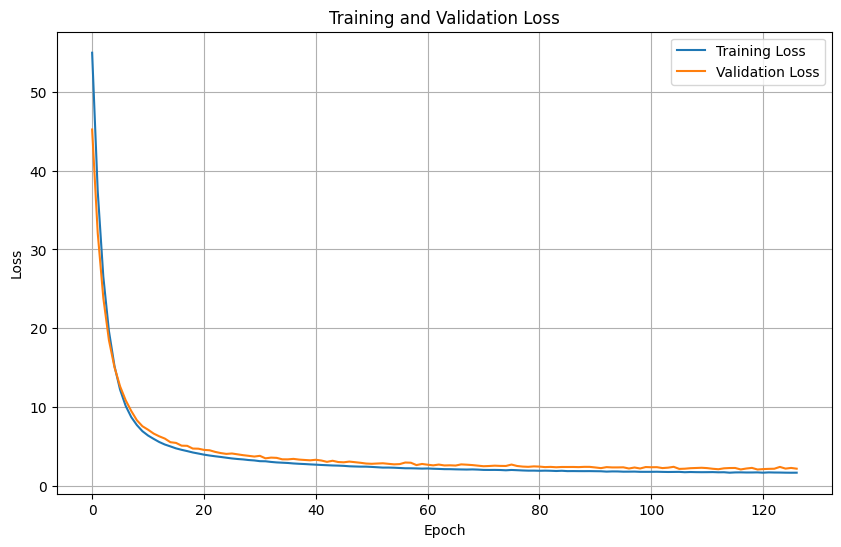

In [11]:
# model wit dropouts layers
mvitl.plots.plot_training_history(history.history, figsize=(10, 6), show=True)

# Predictions
Get predictions for the test set.

In [14]:
# predictions on test data
predictions = []
for batch_test in ds_test:
    predictions.append(model.predict_on_batch(batch_test))
predictions = tf.concat(predictions, axis=0)
predictions = tf.math.argmax(predictions, axis=-1)
predictions = tf.cast(predictions, dtype=tf.uint8)

## Quick evaluation on test data

Quickly calculate accuracy on the test set.

In [15]:
# whole accuracy on test data
accuracy = tf.cast(labels_test == predictions, dtype=tf.uint8)
accuracy = accuracy.numpy().sum() / len(accuracy)
print(f'test_categorical_accuracy: {accuracy:.4f}')

test_categorical_accuracy: 0.8410


In [16]:
# classification report for each class
print(classification_report(labels_test, predictions.numpy()))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33         5
           1       0.78      1.00      0.88         7
           2       0.40      0.40      0.40         5
           3       0.33      0.14      0.20         7
           4       1.00      0.88      0.93         8
           5       1.00      1.00      1.00         5
           6       1.00      0.60      0.75         5
           7       0.91      1.00      0.95        10
           8       1.00      0.67      0.80         6
           9       1.00      1.00      1.00         5
          10       1.00      0.91      0.95        11
          11       0.79      1.00      0.88        11
          12       1.00      1.00      1.00         6
          13       0.67      1.00      0.80         6
          14       1.00      0.67      0.80         6
          15       1.00      0.80      0.89         5
          16       0.83      1.00      0.91        10
          17       0.80    

# Conclusions

I'm confident that with better data augmentation and some tweaking of the training hyperparameters, we could achieve even better results. However, as mentioned earlier, that wasn't my main goal. I was more interested in understanding the architecture of a MobileViT network, and implementing it from scratch was very helpful for that.

Achieving 84% accuracy on the Flowers-102 dataset with a network trained from scratch and around 2M parameters is a good result. This is especially notable given the straightforward approach to data augmentation and the simple training strategy.

MobileViT is an interesting network architecture that combines the strengths of both CNNs and Transformers. This enables simpler and more effective training procedures compared to pure Transformers and often results in slightly better performance than most CNNs with a similar number of parameters.

However, one drawback of MobileViT is its throughput rate. While it performs well, it's inevitably slower than similar-sized CNNs, due to expensive multi-head attention block operations. This lower throughput could be a concern when deploying the network on mobile or low-power devices.

I've just started reading the MobileViT-v2 paper, which promises to address this issue by proposing an alternative block to the classic multi-head attention block. Maybe i'll try to implement also this variant!